<a href="https://colab.research.google.com/github/RichardOgujawa/apple_quality_predictor/blob/main/predicting_apple_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Apple Quality**

## **Project Description**
  "This dataset contains information about various attributes of a set of fruits, providing insights into their characteristics. The dataset includes details such as fruit ID, size, weight, sweetness, crunchiness, juiciness, ripeness, acidity, and quality." - **Kaggle**.

  The goal of this project is to create two models KNN without distance weighting and KNN with distance weighting to predict the quality of the fruit from these characteristics.

---
\
Link to dataset: https://www.kaggle.com/datasets/nelgiriyewithana/apple-quality?resource=download


## **1. Setup**


### **1.1 Imports**

In [ ]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

### **1.2 Utility Functions**

In [ ]:
def percentage_formatter(num):
  return '{:.2f}%'.format(num * 100)

## **2. Data Loading and Initial Exploration**
The data is a csv file which was sourced from kaggle.

### **2.1 Load Data.**

In [ ]:
# Load the data and set the index column to the dataset's id column
apple_df = pd.read_csv('apple_quality.csv')
apple_df.head()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


### **2.2 Initial Exploration**

In [ ]:
# Check out the columns (the columnns will be reshaped for easier readability)
np.array(apple_df.columns).reshape(-1,1)

array([['A_id'],
       ['Size'],
       ['Weight'],
       ['Sweetness'],
       ['Crunchiness'],
       ['Juiciness'],
       ['Ripeness'],
       ['Acidity'],
       ['Quality']], dtype=object)

## **3. Data Pre-processing**

### **3.1 Data Cleaning**

In [ ]:
# Check metadata to see the number of null values and the types of data being stored
apple_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4001 non-null   object 
 8   Quality      4000 non-null   object 
dtypes: float64(7), object(2)
memory usage: 281.4+ KB


#### **3.1.1 Handling Null Values**
There are 4001 records, and all the rows have only 4000 non-null values bar one column, Acidity, let's see why.

In [ ]:
# Return all the rows that have any column in it with a null value
apple_df[apple_df.isnull().any(axis=1)]

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Created_by_Nidula_Elgiriyewithana,NaN


It appears that the last row, has null values, up until Acidity, because it's simply used to **credit** the creator of the dataset. So we can drop it.

In [ ]:
# Final row is just for credits, so it can be removed by removing any rows (axis=0) with null values in them
apple_df = apple_df.dropna(axis=0)

Check all the unique values in the columns to get a sense of what kind of values are stored in them.

#### **3.1.2 Unique Values in Columns**

In [ ]:
# Store all the unique values in a dictionary
unique_values = {}
# Add, as key-value pairs, the unique values to the unique_values dictionary
cols = [col for col in apple_df.columns]
for col in cols:
  unique_values[col] = apple_df[col].unique()

unique_values

{'A_id': array([0.000e+00, 1.000e+00, 2.000e+00, ..., 3.997e+03, 3.998e+03,
        3.999e+03]),
 'Size': array([-3.97004852, -1.19521719, -0.29202386, ..., -2.6345153 ,
        -4.00800374,  0.27853965]),
 'Weight': array([-2.51233638, -2.83925653, -1.35128199, ..., -2.13824672,
        -1.77933711, -1.71550503]),
 'Sweetness': array([ 5.34632961,  3.66405876, -1.73842916, ..., -2.44046129,
         2.36639697,  0.12121725]),
 'Crunchiness': array([-1.01200871,  1.58823231, -0.34261593, ...,  0.65722289,
        -0.20032937, -1.15407476]),
 'Juiciness': array([1.84490036, 0.8532858 , 2.83863551, ..., 2.19970859, 2.16143512,
        1.2666774 ]),
 'Ripeness': array([ 0.3298398 ,  0.86753008, -0.03803333, ...,  4.76385918,
         0.21448838, -0.77657147]),
 'Acidity': array(['-0.491590483', '-0.722809367', '2.621636473', ..., '-1.334611391',
        '-2.229719806', '1.599796456'], dtype=object),
 'Quality': array(['good', 'bad'], dtype=object)}

There appears to be no other values that need to be removed.

### **3.2 Data Transformation**

#### **3.2.1 Data Type Conversion**
Acidity values are stored as a strings, which is evident from the exploration of the unique values in each column. Let's cast them to floats, because machine algorithms typically expect values to be passed in as numeric values.


In [ ]:
apple_df['Acidity'] = apple_df['Acidity'].astype(float)

#### **3.2.2. Convert Target to Numeric Values**
We also want to convert the target to numeric values for a similar reasons to the one explained earlier.

In [ ]:
# Convert target to numeric values
apple_df['Quality'] = apple_df['Quality'].apply(lambda x : 1 if x == 'good' else 0)
apple_df

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,1
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,1
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,0
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,1
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,1
...,...,...,...,...,...,...,...,...,...
3995,3995.0,0.059386,-1.067408,-3.714549,0.473052,1.697986,2.244055,0.137784,0
3996,3996.0,-0.293118,1.949253,-0.204020,-0.640196,0.024523,-1.087900,1.854235,1
3997,3997.0,-2.634515,-2.138247,-2.440461,0.657223,2.199709,4.763859,-1.334611,0
3998,3998.0,-4.008004,-1.779337,2.366397,-0.200329,2.161435,0.214488,-2.229720,1


Let's check the dataset again to make sure everything is okay:

In [ ]:
apple_df.info()
# Check 1: No null values
# Check 2: All the values are numeric in nature

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4000 non-null   float64
 8   Quality      4000 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 312.5 KB


### **3.3 Check for Class Imbalances**
Make sure that the classes are evenly distributed amongst the samples in the dataset.**bold text**

In [ ]:
# Check for class imbalances
apple_df['Quality'].value_counts()/len(apple_df) * 100

1    50.1
0    49.9
Name: Quality, dtype: float64

## **4. Feature Engineering**

### **4.1. Explore Features to Ensure No Multicolinearity**
Something that would be interesting to look into is the relationship between the features, to investigate whether there are any correlations between them - multicollinearity. This is generally not desirable as it can "prevent predictive models from producing accurate predictions by increasing model complexity and overfitting." - IBM

<Axes: >

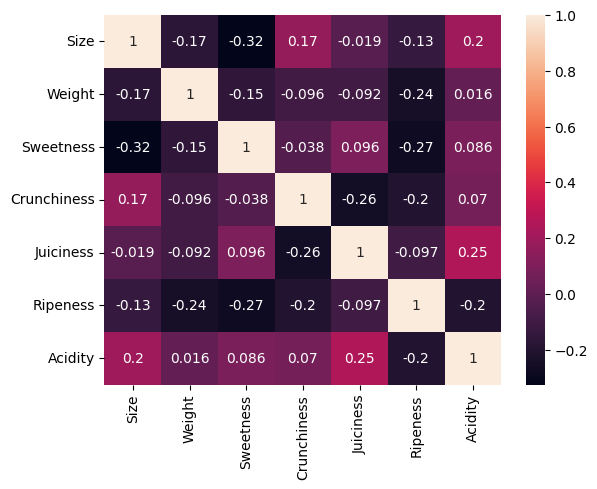

In [ ]:
# Feature columns = columns without id column and target
features_cols = apple_df.drop('A_id', axis=1).columns[:-1]
features_cols

# See if there's any correlation between the features
corr_matrix = apple_df[features_cols].corr()
sns.heatmap(corr_matrix, annot=True)

There's a low correlation between them so we're okay.

### **4.2. Correlation Between Features and Target**
Now let's see if there is any correlation between the features and the target.

In [ ]:
# See the correlation between the features and the target, and sort them
corr_matrix = apple_df.corr()['Quality'].drop(['Quality', 'A_id']).sort_values(ascending=False)
corr_matrix

Juiciness      0.260223
Sweetness      0.250998
Size           0.244007
Weight         0.001421
Acidity       -0.007697
Crunchiness   -0.012376
Ripeness      -0.264315
Name: Quality, dtype: float64

When the df is sorted in descending order it appears that **Juiciness**, **Sweetness** and **Size** are the attributes which matter most in determining the quality of an apple. However, when it comes to correlation, we have to look at magnitude, not just the sign, as this tells us how correlated the values are and the sign just indicates in which direction.

In [ ]:
corr_matrix = pd.DataFrame()

# Store the correlation coefficients separately since it will be re-used below more than once
correlation_coeffs = apple_df.corr()['Quality'].drop(['Quality', 'A_id'])

# Separate the correlation into magnitude and relationship type
corr_matrix['Magnitude'] = correlation_coeffs.apply(lambda x : abs(x))
corr_matrix['Relationship'] = correlation_coeffs.apply(lambda x : 'Negative Relationship' if x < 0 else 'Positive Relationship')

# Sort by the magnitude
corr_matrix.sort_values(by='Magnitude', ascending=False)

,Magnitude,Relationship
Ripeness,0.264315,Negative Relationship
Juiciness,0.260223,Positive Relationship
Sweetness,0.250998,Positive Relationship
Size,0.244007,Positive Relationship
Crunchiness,0.012376,Negative Relationship
Acidity,0.007697,Negative Relationship
Weight,0.001421,Positive Relationship


### **4.3 Define Featues and Label**
Now we can see that the top three attributes which dictate the quality of an apple are actually **Ripeness**, **Juiciness**, and **Sweetness**.

In [ ]:
# Define initial features (dropping target and index column)
X = apple_df.drop(columns=['Quality', 'A_id'])

# Define initial labels
y = apple_df['Quality']

In [ ]:
# Make sure everything looks as expected
X, y

(          Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness  \
 0    -3.970049 -2.512336   5.346330    -1.012009   1.844900  0.329840   
 1    -1.195217 -2.839257   3.664059     1.588232   0.853286  0.867530   
 2    -0.292024 -1.351282  -1.738429    -0.342616   2.838636 -0.038033   
 3    -0.657196 -2.271627   1.324874    -0.097875   3.637970 -3.413761   
 4     1.364217 -1.296612  -0.384658    -0.553006   3.030874 -1.303849   
 ...        ...       ...        ...          ...        ...       ...   
 3995  0.059386 -1.067408  -3.714549     0.473052   1.697986  2.244055   
 3996 -0.293118  1.949253  -0.204020    -0.640196   0.024523 -1.087900   
 3997 -2.634515 -2.138247  -2.440461     0.657223   2.199709  4.763859   
 3998 -4.008004 -1.779337   2.366397    -0.200329   2.161435  0.214488   
 3999  0.278540 -1.715505   0.121217    -1.154075   1.266677 -0.776571   
 
        Acidity  
 0    -0.491590  
 1    -0.722809  
 2     2.621636  
 3     0.790723  
 4     0.501984  
 .

#### **4.3.1 Train-Val-Test Split**

In [ ]:
# Train-val-test split (80/10/10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# Split the test into 10% and give 10% to validation set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

full_len = len(X)
print(f"Train-Val-Test Split:", f"* X_train : {len(X_train)/full_len}", f"* X_val : {len(X_val)/full_len}", f"* X_test : {len(X_val)/full_len}", sep='\n')

Train-Val-Test Split:
* X_train : 0.8
* X_val : 0.1
* X_test : 0.1


#### **4.3.2 Normalising Data**
To ensure that the optimisation process isn't affected by variations in the scales of the data in each column, the data is normalised using standard scaler.

In [ ]:
# Fit the scaler on the train data and then transform both train and test data using the fitted scaler
"""
Why? We don't want test/val data leakage. I.e. we only want to fit to the train data and not the test or val data, because otherwise it will undermine the ability of the ability
of these dataset to model real world unseen data, as the model would be capturing and incorporating information about them into the resulting model.
"""
scaler = StandardScaler()
# Fit to and then transform X_train
X_train_scaled = scaler.fit_transform(X_train)
# Transform X_test and X_val using the fitted scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_test_scaled

array([[-1.18813886, -1.39192745, -2.25334851, ..., -1.09137098,
         2.22585759, -2.32475761],
       [ 1.55129059, -0.19944407, -0.47872157, ...,  0.43249551,
        -0.24916018,  0.94578964],
       [-0.61057997,  0.87341995,  1.33648905, ..., -0.97916136,
        -0.12537083, -0.78345436],
       ...,
       [ 0.07144706,  0.00385666, -1.41142829, ...,  1.30838709,
         1.40318305, -1.2686706 ],
       [-0.38701043,  0.87027159,  0.65863011, ..., -0.36651615,
        -0.55387367, -0.6765441 ],
       [ 1.65238324,  1.20602779, -0.28811013, ..., -0.42709773,
        -1.64517884,  0.27776477]])

#### **4.3.3  Dimensionalty Reduction**

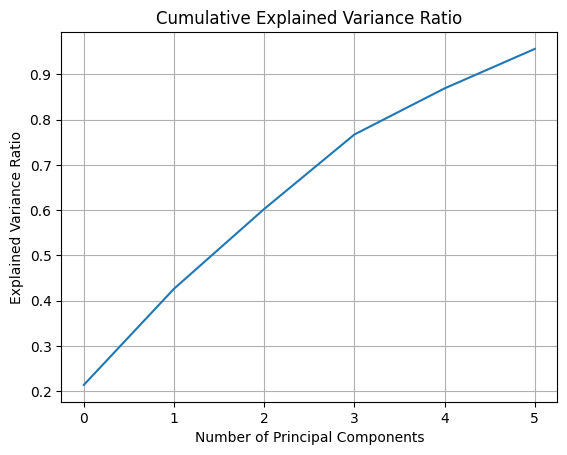

[0.21399194 0.212363   0.17617576 0.16450019 0.10184988 0.08717743]


In [ ]:
# Principle Component Analysis (PCA)
# First let's check the explained variance ratio
"""
We want to check this first to get a sense of how important/useful each PCA component is in explaining
the variance in the dataset. Using only the highest quality components that offer the most
value, in that they explain most the variability in the dataset may result in a better model.
"""
# First let's check all 7 components
pca = PCA(0.95)
# Fit to the training data
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)
# Get the explained_var_ratio
exp_var_ratio = pca.explained_variance_ratio_

# Plot cumulative explained variance ratio to see the contribution of each component to the overall explained variance
cumulative_variance_ratio = np.cumsum(exp_var_ratio)
plt.plot(cumulative_variance_ratio)

# Add label axes
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')

# Show the grid
plt.grid(True)

# Show the plot
plt.show()

# Print the explained variance ratio values
print(exp_var_ratio)

In [ ]:
'{:.2f}%'.format(sum(exp_var_ratio) * 100)

'95.61%'

6 components can be used to explain almost 95% of the variance in the dataset. So, we'll work with just the top 6 principle components.

## **5. Train the model**


### **5.1 Tuning KNN Model**
Grid Search CV will be used to do hyper-parametric tuning, and find the best model.

In [ ]:
# Let's find the best weighted and non-weighted classifier

# Classifier
# KNN without distance weighting
knn = KNeighborsClassifier()
# Parameters to test
parameters = {
    'n_neighbors' : range(2, 5),
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'p' : [1.0, 2.0],
}

# Find the best model
"""
'Accuracy' was used as the scoring metric, to weigh up the different models, because it's typically a metric used when
there aren't any class imbalances in the dataset, and the goal of the model has no bias in terms of which class it wants to classify more accurately.
"""
clf = GridSearchCV(estimator=knn, param_grid=parameters, cv=10, scoring='accuracy').fit(X_train_pca, y_train)

Let's see how this best model performs so far.

In [ ]:
X_val_pred = clf.predict(X_val_pca)
accuracy_score(y_val, X_val_pred)

0.8375

In [ ]:
X_train_pred = clf.predict(X_train_pca)
accuracy_score(y_train, X_train_pred)

0.9128125

Let's see if we can make it any more accurate by adding another hyperparameter.

In [ ]:
# Leaf size is only compatible with ball tree and kd tree
# So we'll test the different leaf sizes separately
"""
  The smaller the leaf size, the deeper the tree structure with more
  leaf nodes. Each leaf node contains fewer data points. It does
  increase computational overhead however, but for smaller datasets
  the effects of this are less felt and therefore worth choosing.
"""
# Pass the best params so far into the base classifier
knn = KNeighborsClassifier(**clf.best_params_)
# Below are the leaf sizes we want to test
parameters = {
    'leaf_size': [1, 5, 10, 20, 30]
}

# Find best params with leaf size now included in grid search cv
clf_2 = GridSearchCV(knn, parameters, scoring='accuracy', cv=10)
clf_2.fit(X_train_pca, y_train)
# Set the best estimator to the knn classifier with no weights
knn_no_weight = clf_2.best_estimator_
knn_no_weight

KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, n_neighbors=3, p=1.0)

In [ ]:
# Accuracy on Validation set
X_val_pred = knn_no_weight.predict(X_val_pca)
accuracy_score(y_val, X_val_pred)

0.8375

Nope.

In [ ]:
# Accuracy on Train set
X_train_pred = knn_no_weight.predict(X_train_pca)
accuracy_score(y_train, X_train_pred)

0.9128125

It appears that the model is overfitting. Some methods which might help overcome this is increasing the size of the dataset, however more data wasn't able to be obtained. Another method would be decreasing the number of nearest neighbors, however, the nearest neighbours are pretty low already.

### **5.2 Tuning KNN Model (Distance-Weighted)**


In [ ]:
# Fit the model and get the accuracy score
knn = KNeighborsClassifier(weights='distance')
# Parameters to test
parameters = {
    'n_neighbors' : range(2, 5),
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'p' : [1.0, 2.0],
    'metric' : ['euclidean', 'manhattan']
}
# Configure the classifier
clf_weighted = GridSearchCV(estimator=knn, param_grid=parameters, cv=5, scoring='accuracy')
# Fit classifier to find best params
clf_weighted.fit(X_train_pca, y_train)
clf_weighted.best_params_

{'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 4, 'p': 1.0}

Once again, let's see how accurate this model is.

In [ ]:
# Accuracy on Validation set
X_val_pred = clf_weighted.predict(X_val_pca)
accuracy_score(y_val, X_val_pred)

0.84

In [ ]:
# Accuracy on Train set
X_train_pred = clf_weighted.predict(X_train_pca)
accuracy_score(y_train, X_train_pred)

1.0

It appears to be slightly more accurate

In [ ]:
# Pass the best params so far into the base classifier
knn = KNeighborsClassifier(**clf_weighted.best_params_)
# Below are the leaf sizes we want to test
parameters = {
    'leaf_size': [1, 5, 10, 20, 30]
}

# Find best params with leaf size now included in grid search cv
clf_weighted_2 = GridSearchCV(knn, parameters, cv=5)
clf_weighted_2.fit(X_train_pca, y_train)
# Set the best estimator to the knn classifier with no weights
knn_weighted = clf_weighted_2.best_estimator_
knn_weighted

KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, metric='euclidean',
                     n_neighbors=4, p=1.0)

In [ ]:
from sklearn.metrics import accuracy_score
y_pred_no_weight = knn_no_weight.predict(X_val_pca)
y_pred_weighted = knn_weighted.predict(X_val_pca)

no_weight_score = accuracy_score(y_pred_no_weight, y_val)
weighted_score = accuracy_score(y_pred_weighted, y_val)

print(f"no_weight_score:{no_weight_score}", f"Weighted KNN Score:{weighted_score}")

no_weight_score:0.8375 Weighted KNN Score:0.8325


Let's see if we can improve the model to get a better score.

## **6. Evaluation**

### **6.1 Cross-Validation**

Let's get a sense of how the model fairs whe cross-validated. This is a process whereby the data will be split up into n folds, 1 of those folds will be used to train the data and the n-1 remaining folds will be used to test the resulting trained model. This process is repeated a number of times, changing which fold is the test fold each time.

The .mean() method is called afterwards to get the average of the scores.

In [ ]:
cv_scores = [
  {
    # Train data + KNN model without weights
    'Configuration' : 'mean_train_score_knn',
    'Score' : cross_val_score(knn_no_weight, X_train_pca, y_train, cv=5).mean()
  },
  {
    # Test data + KNN model without weights
    'Configuration' : 'mean_test_score_knn' ,
    'Score' : cross_val_score(knn_no_weight, X_test_pca, y_test, cv=5).mean()
  },
  {
    # Train data + KNN model with distance weighting
    'Configuration': 'mean_score_knn_weighted',
    'Score' : cross_val_score(knn_weighted, X_train_pca, y_train, cv=5).mean()
  },
  {
    # Test data + KNN model with distance weighting
    'Configuration' : 'mean_score_pca_knn_weighted',
    'Score' : cross_val_score(knn_weighted, X_test_pca, y_test, cv=5).mean()
  }
]

In [ ]:
# CV scores df
cv_df = pd.DataFrame(columns=['Configuration', 'Score'], data=cv_scores)
# Check the sorted dataframe
cv_df.sort_values(by='Score', ascending=False)

,Configuration,Score
0,mean_train_score_knn,0.832500
2,mean_score_knn_weighted,0.828125
3,mean_score_pca_knn_weighted,0.797500
1,mean_test_score_knn,0.785000


### **6.1 Classification Report**

In [ ]:
accuracy_df_data = []

train_test_preds = [
    {
    'clf' : 'KNN without weighting',
    'data' : 'train',
    'pred' : knn_no_weight.predict(X_train_pca)
    },
    {
    'clf' : 'KNN without weighting',
    'data' : 'test',
    'pred' : knn_no_weight.predict(X_test_pca)
    },
    {
    'clf' : 'KNN with distance weighting',
    'data' : 'train',
    'pred' : knn_weighted.predict(X_train_pca)
    },
    {
    'clf' : 'KNN with distance weighting',
    'data' : 'test',
    'pred' : knn_weighted.predict(X_test_pca)
    }
]
# The weighted average takes into consideration class imbalances
for pred_dict in train_test_preds:
  # Get the prediction from the dict
  y_test_pred = pred_dict['pred']
  y_test_true = y_test if pred_dict['data'] == 'test' else y_train
  # Append the data to the data going into the df
  accuracy_df_data.append({
      'Classifier' : pred_dict['clf'],
      'Data Source' : pred_dict['data'],
      # Weighted average takes into consideration class imbalances
      'Precision Score' : percentage_formatter(precision_score(y_test_true, y_test_pred, average='weighted')),
      'Recall Score' : percentage_formatter(recall_score(y_test_true, y_test_pred, average='weighted')),
      'F1 Score' : percentage_formatter(f1_score(y_test_true, y_test_pred, average='weighted')),
      'Accuracy Score' : percentage_formatter(accuracy_score(y_test_true, y_test_pred))
  })

In [ ]:
# Get the columna from accuracy_df_data
cols = accuracy_df_data[0].keys()

# Construct the dataframe
accuracy_df = pd.DataFrame(columns=cols, data=accuracy_df_data)

# Show df
accuracy_df

,Classifier,Data Source,Precision Score,Recall Score,F1 Score,Accuracy Score
0,KNN without weighting,train,91.29%,91.28%,91.28%,91.28%
1,KNN without weighting,test,82.26%,82.00%,82.00%,82.00%
2,KNN with distance weighting,train,90.00%,89.53%,89.51%,89.53%
3,KNN with distance weighting,test,81.93%,81.75%,81.69%,81.75%


## **7. Conclusion**
The results in the above dataframe shows that there isn't much difference between the two predictive models. However, the KNN model without distance weighting appears to be a marginally better predictor.

To improve the model, perhaps it could've been used as part of ensemble rather than on it's own.